In [1]:
import numpy as np
import theano
import theano.tensor as T
from theano import function as F
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
from scipy import optimize

In [12]:
class RNN:
    
    def __init__(self, τ, α, A, ttar, numsteps, dt, numneur, bptt_trunc, in_stim):
        self.τ = τ
        self.α = α
        self.A = A
        self.ttar = ttar
        self.numsteps = numsteps
        self.dt = dt
        self.numneur = numneur
        self.bptt_trunc = bptt_trunc
        
        
        # Randomly initialize the network parameters
        
        J = np.random.normal(loc=0., scale=(1./self.numneur), 
                             size=[self.numneur, self.numneur])
        B = np.random.uniform(low=-1., high=1., size=2)
        cx = 1.
#         wo = np.random.uniform(low=-1., high=1., size=self.numneur)
        wo = np.zeros(self.numneur)
        cz = 1.
        x_init = np.abs(np.random.normal(size=self.numneur))
        # Theano: Created shared variables
        self.u = theano.shared(name='u', value=in_stim.astype(theano.config.floatX))
        self.J = theano.shared(name='J', value=J.astype(theano.config.floatX))
        self.B = theano.shared(name='B', value=B.astype(theano.config.floatX))
        self.cx = theano.shared(name='cx', value=cx)
        self.wo = theano.shared(name='wo', value=wo.astype(theano.config.floatX))
        self.cz = theano.shared(name='cz', value=cz)
        self.xo = theano.shared(name='xo', value=x_init.astype(theano.config.floatX))
        self.zo = theano.shared(name='zo', value=cz)
    
    def nonlin(self, x):
#         return x
        return T.tanh(x)
    
    def update_state(self, x, J, B, cx, u):
#         ρ = np.random.normal(scale=0.01, size=self.numneur)
        x_dot = (1. / (1.*self.τ)) * (- x + T.dot(J, self.nonlin(x)) + 
                                 T.dot(B, u) + cx)# + ρ)
        
        return x + (self.dt * x_dot)

    def activity(self, x, wo, cz):
        return T.dot(wo, self.nonlin(x)) + cz
    
    def target_traj(self, time):
        return self.A * (np.exp(time / (self.α * self.ttar)) - 1.)
    
    def cost(self, Z):
        f = self.target_traj(np.arange(0., self.numsteps, self.dt))
        return (1./ self.numsteps) * T.sum((Z - f)**2)
    
    def up_state_act(self, u, x, z, J, wo, cz, B, cx):
        x = self.update_state(x, J, B, cx, u)
        z = self.activity(x, wo, cz)
        return x, z

    def rnn_unroll(self):
        u = self.u
        J = self.J
        B = self.B
        cx = self.cx
        wo = self.wo
        cz = self.cz
        xo = self.xo
        zo = self.zo
        
        [X, Z], updates = theano.scan(fn=self.up_state_act,
                                      sequences=u,
                                      outputs_info=[xo,
                                                    zo],
                                      non_sequences=[J, wo, cz, B, cx],
                                      n_steps=self.numsteps,
#                                       truncate_gradient=self.bptt_trunc,
                                      strict=True)
        
        plt.plot(F([], X)()[:, 0])
#         plt.yscale('log')
        plt.show()

        L = self.cost(Z)
        grad_list = T.grad(L, [J, wo, cz, xo, B, cx])  
        
        return X, Z, L, grad_list
    
    def get_network(self):
#         X, Z, L, grad_list = self.rnn_unroll()
#         X_func = F([], X)
        W_func = F([], self.J)
        plt.imshow(W_func())
        plt.colorbar()
        plt.show()
        
        
    def th_to_num(self, thvar):
        return F([], thvar)()
    
    def pars_to_th(self, pars):
        ind = self.numneur**2
        J = pars[:ind].reshape([-1, self.numneur])
        wo = pars[ind:ind+self.numneur]
        ind += self.numneur
        
        cz = pars[ind]
        ind +=1
        
        xo = pars[ind:ind+self.numneur]
        ind += self.numneur
        
        B = pars[ind:ind+2]
        ind += 2
        
        cx = pars[-1]
        
        
        self.J.set_value(J.astype((theano.config.floatX)))
        self.wo.set_value(wo.astype((theano.config.floatX)))
        self.cz.set_value(cz)
        self.xo.set_value(xo.astype((theano.config.floatX)))
        self.B.set_value(B.astype((theano.config.floatX)))
        self.cx.set_value(cx)
        
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
        im1 = ax1.imshow(J, aspect='auto', origin='lower')
        fig.colorbar(im1, ax=ax1)
        
        ax2.plot(wo, label='wts')
        ax2.legend()
        plt.show()
        
    
    def lbfgs_cost(self, pars):
        self.pars_to_th(pars)
        X, Z, L, grad_list = self.rnn_unroll()
        L = self.th_to_num(L)
        print('Cost:', L)
        
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
        ax1.plot(F([], Z)(), label='Z')
        ax1.plot(self.target_traj(time=np.arange(numsteps)))
        ax1.legend()
        
        ax2.plot(F([], X)())
        plt.show()
        
        grad_list = self.th_to_num(grad_list)
        grad_pars = np.hstack([grad_list[0].flatten(), 
                               grad_list[1],
                               [grad_list[2]],
                               grad_list[3],
                               grad_list[4],
                               [grad_list[5]]])
        
        return L, grad_pars
    
    def grad_desc_lbfgs(self):
        J = self.th_to_num(self.J)
        wo = self.th_to_num(self.wo)
        cz = self.th_to_num(self.cz)
        xo = self.th_to_num(self.xo)
        B = self.th_to_num(self.B)
        cx = self.th_to_num(self.cx)
        
        pars = np.hstack([J.flatten(), wo, [cz], xo, B, [cx]])
        
        pars = optimize.minimize(self.lbfgs_cost, 
                                 pars, 
                                 method='L-BFGS-B', 
                                 jac=True).x
        
    
    def grad_desc(self):
        ct = 0
        lr = .1
        cost_list = []
        while ct<10:
            print(ct)
            X, Z, L, grad_list = self.rnn_unroll()
            [dJ, dwo, dcz, dxo, dB, dcx] = grad_list
            cost_func = F([], L)
            
            #Updates
            self.J = self.J - lr*dJ
            self.wo = self.wo - lr*dwo
            self.cz = self.cz - lr*dcz
            self.xo = self.xo - lr*dxo
            self.B = self.B - lr*dB
            self.cx = self.cx - lr*dcx

            cost_list.append(cost_func())
            fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))
            
            Z_func = F([], Z)
            ax1.plot(Z_func(), label='Z')
            ax1.plot(self.target_traj(time=np.arange(numsteps)))
            ax1.legend()
            
            W_func = F([], self.J)
            im2 = ax2.imshow(W_func(), aspect='auto', origin='lower')
            fig.colorbar(im2, ax=ax2)
            
            X_func = F([], X)
            im3 = ax3.imshow(X_func().T, aspect='auto')
            fig.colorbar(im3, ax=ax3)
            
            plt.show()
            ct += 1
        plt.plot(cost_list)
        plt.show()
        


In [13]:
numneur = 200
ttar = 2000.
τ = 10.
α = 2.8
A = 3.
dt = 1.
numsteps = 3300
bptt_trunc = 4

ran = 500
noisec = np.random.normal(scale=.005, size=ran)
in_stim = np.zeros([numsteps, 2])
in_stim[100:ran+100, 0] = noisec
in_stim[100:110, 1] = 0.1

rnn = RNN(τ, α, A, ttar, numsteps, dt, numneur, bptt_trunc, in_stim) 


In [ ]:
rnn.get_network()


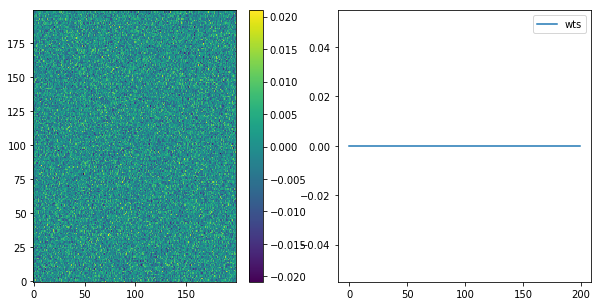

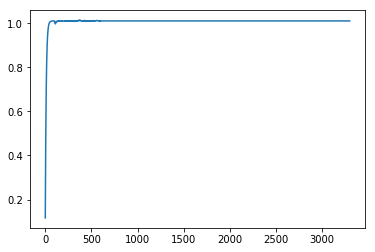

Cost: 0.4878009240878436


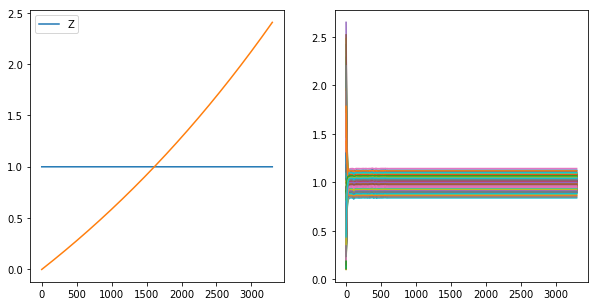

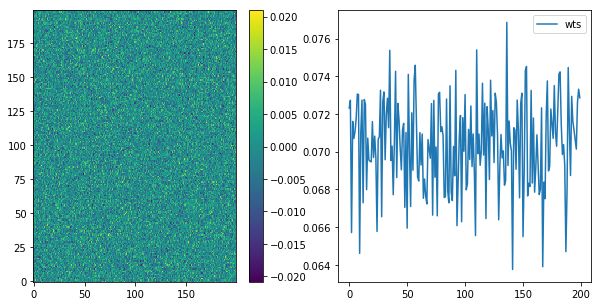

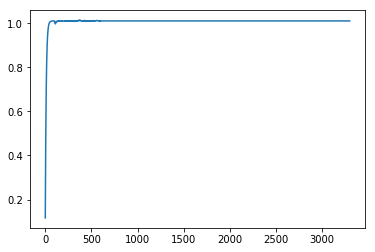

Cost: 114.5941267175705


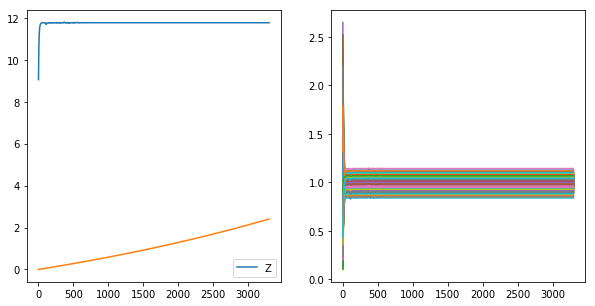

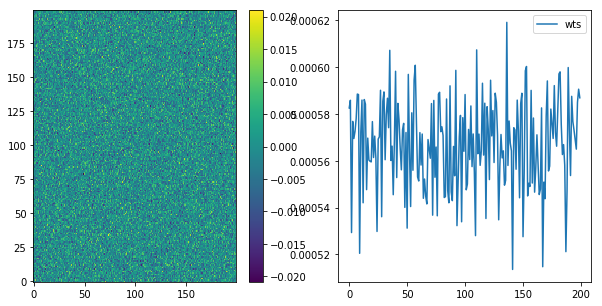

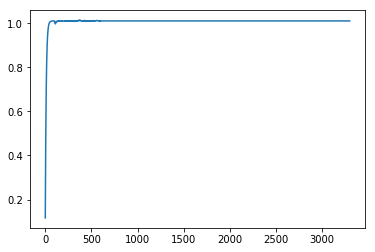

Cost: 0.480274791124092


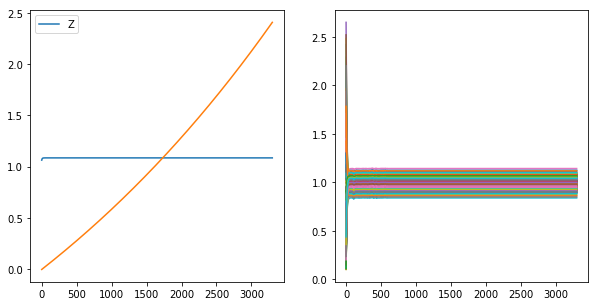

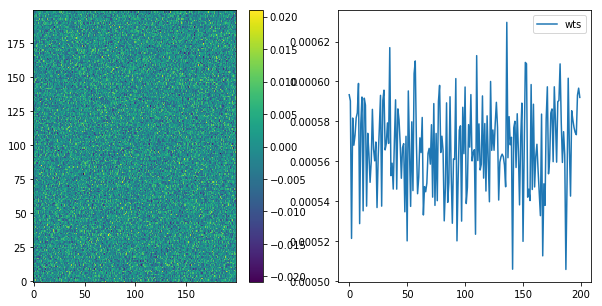

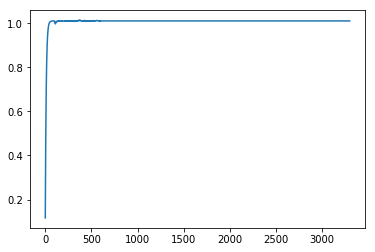

Cost: 0.4802726617397575


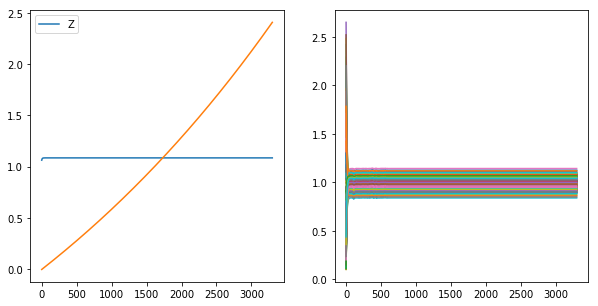

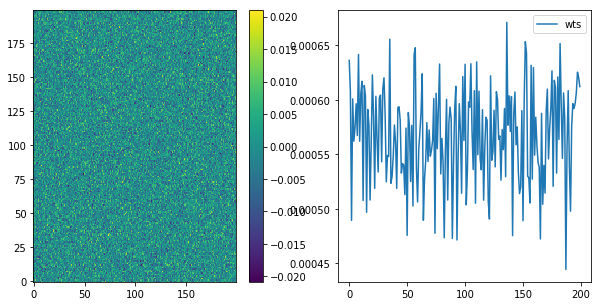

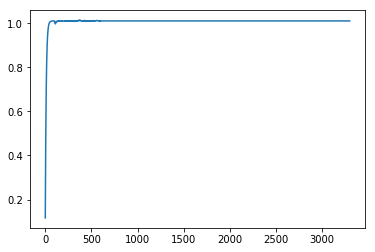

Cost: 0.480264147829845


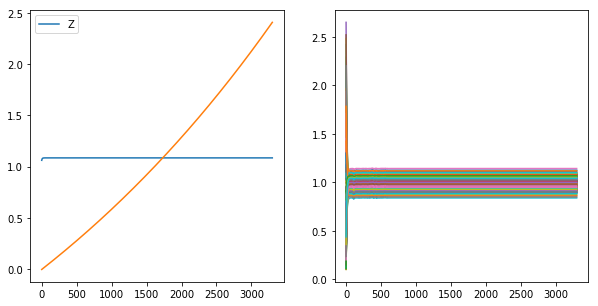

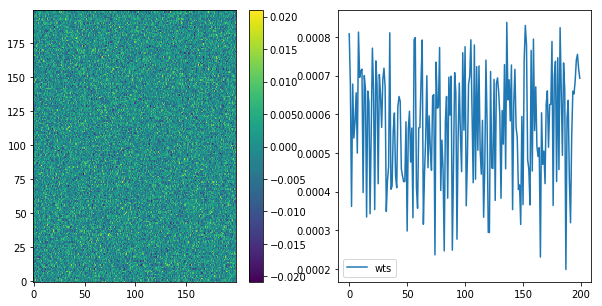

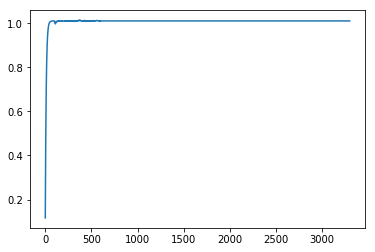

Cost: 0.48023015022697996


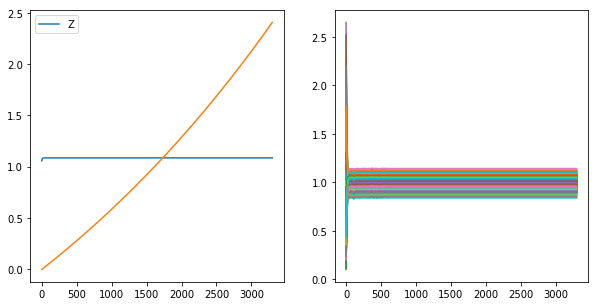

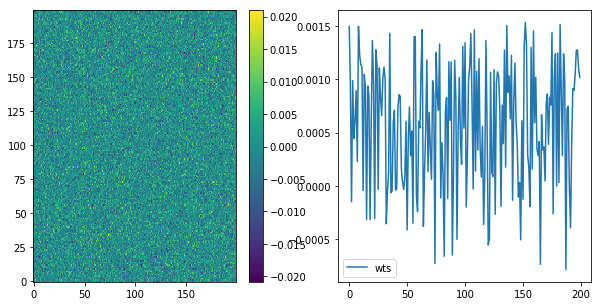

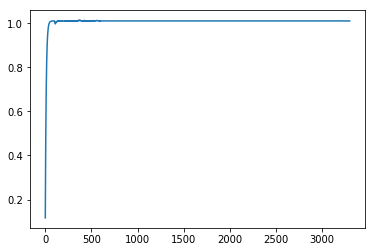

Cost: 0.4800950882706735


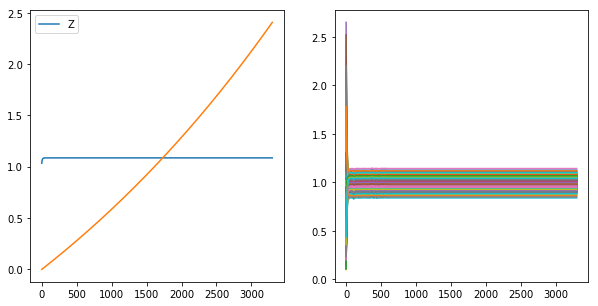

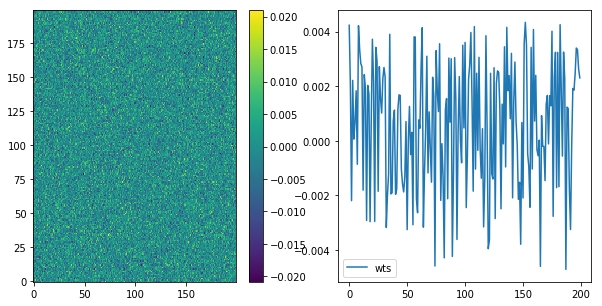

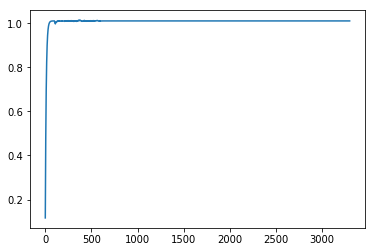

Cost: 0.4795696874178107


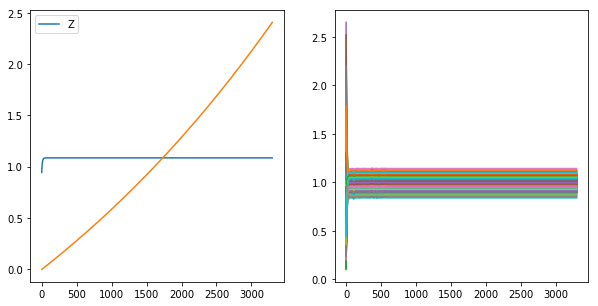

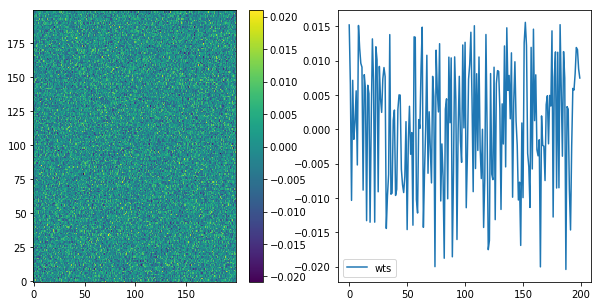

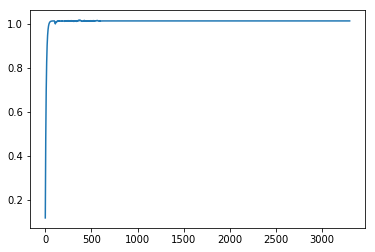

Cost: 0.47770516077602626


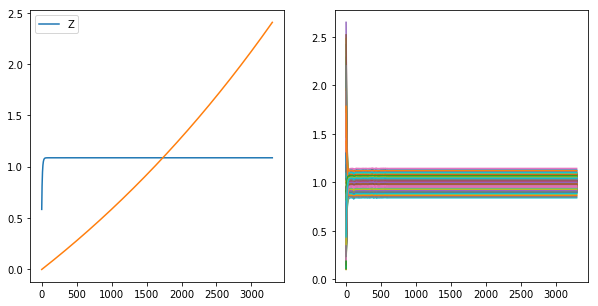

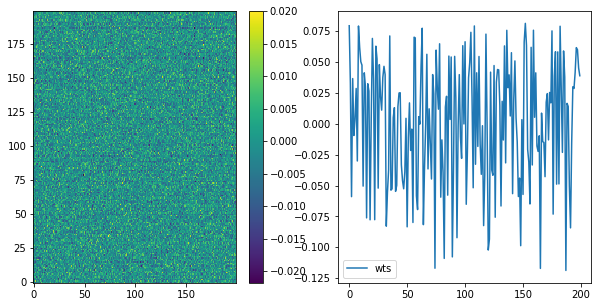

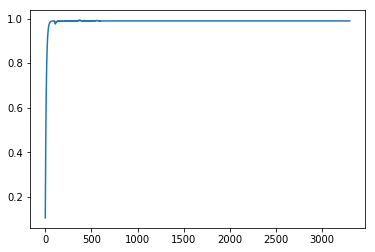

Cost: 0.7569397566684851


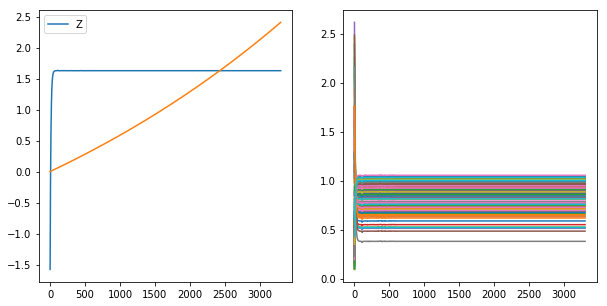

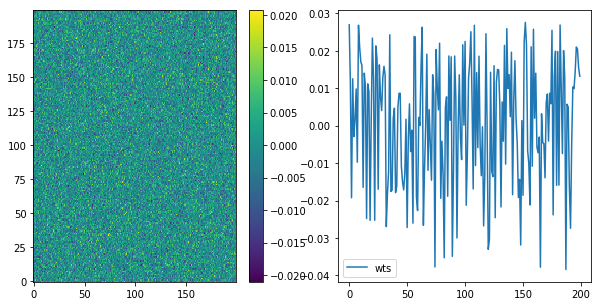

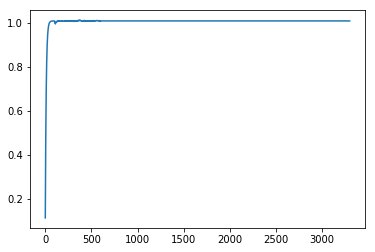

Cost: 0.4765722632634715


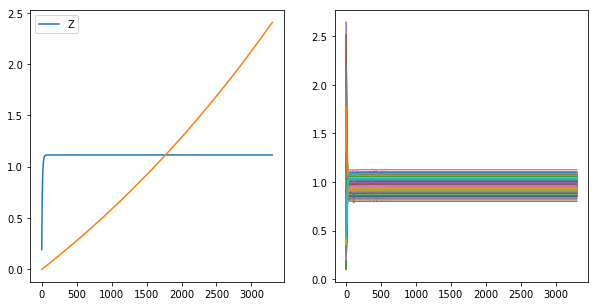

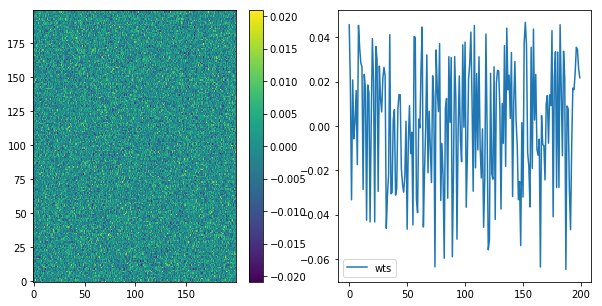

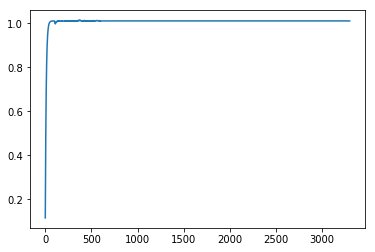

Cost: 0.474467816193631


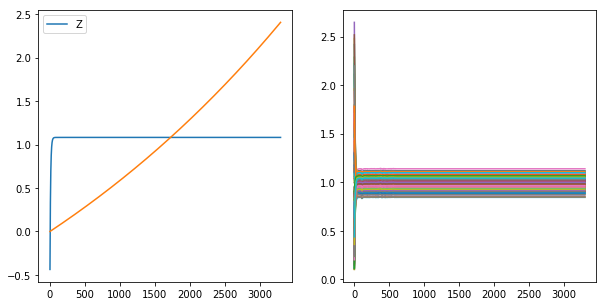

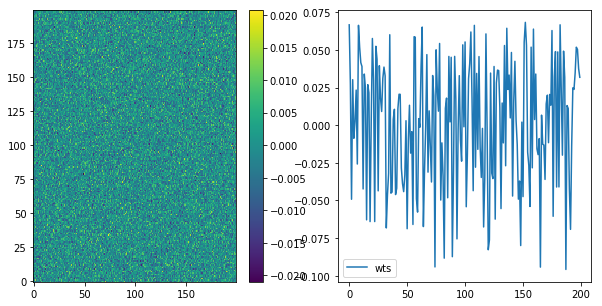

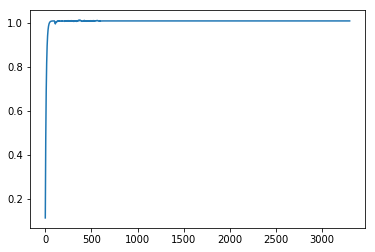

Cost: 0.4742137460444657


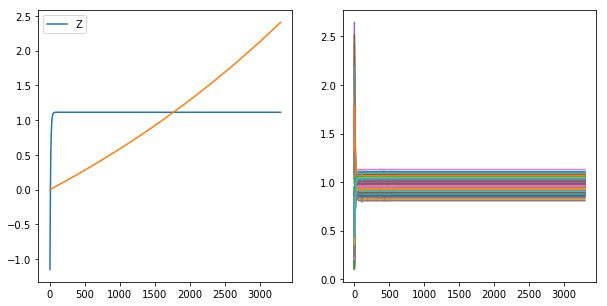

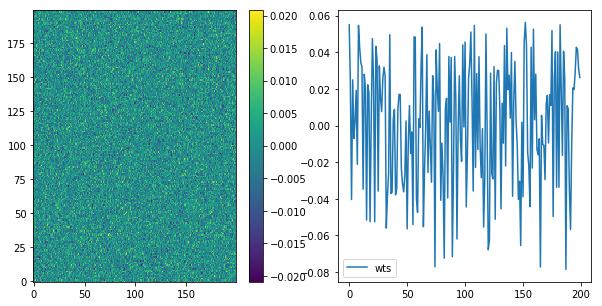

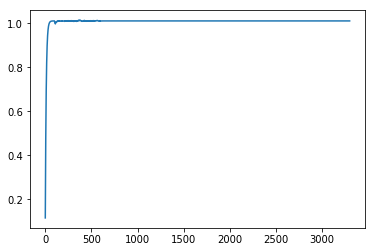

Cost: 0.47394359787598533


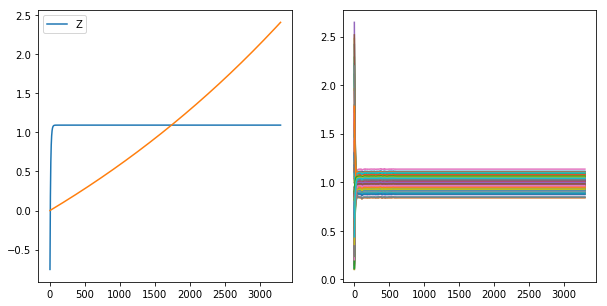

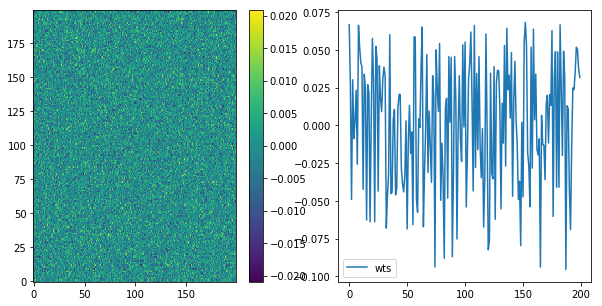

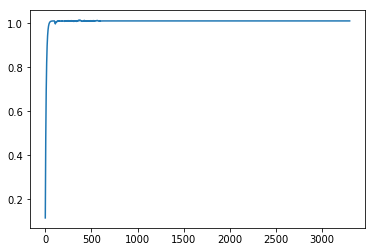

Cost: 0.4738442647690223


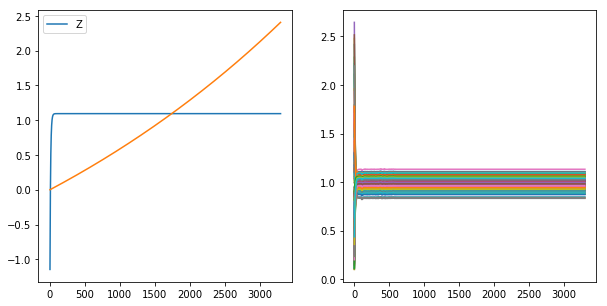

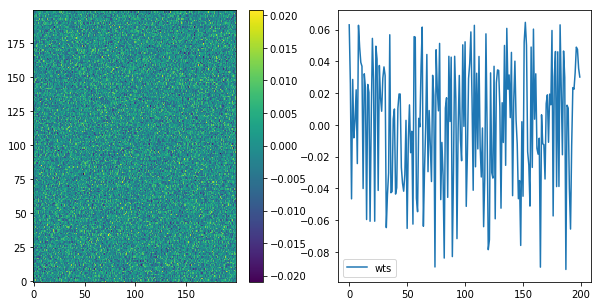

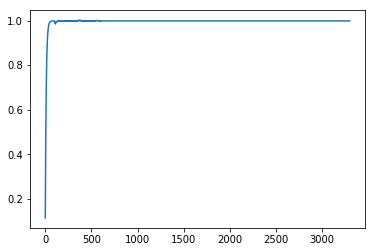

Cost: 0.4737760609869996


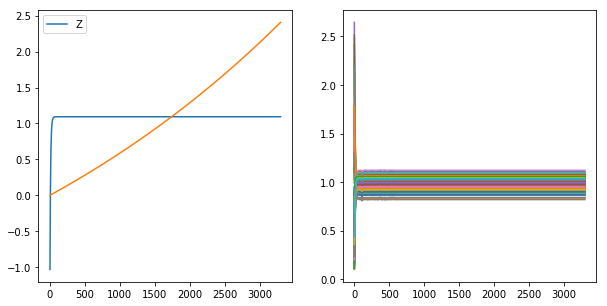

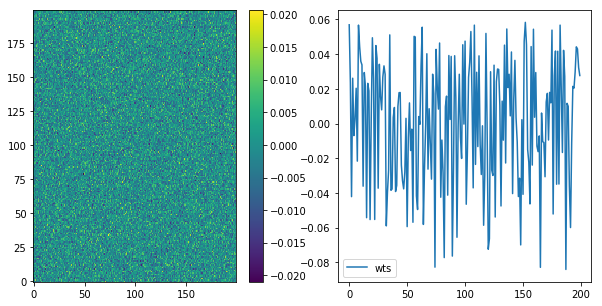

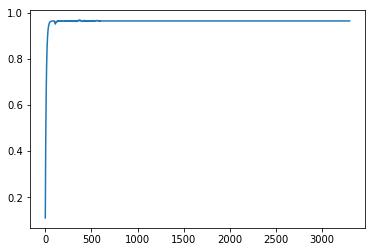

Cost: 0.4736891942181778


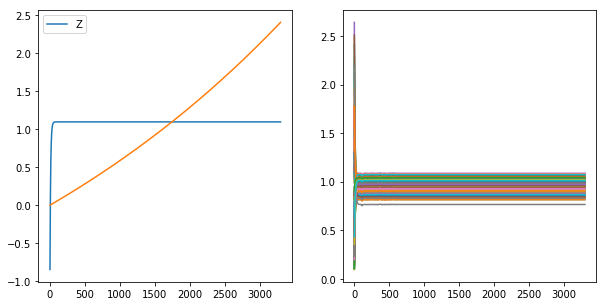

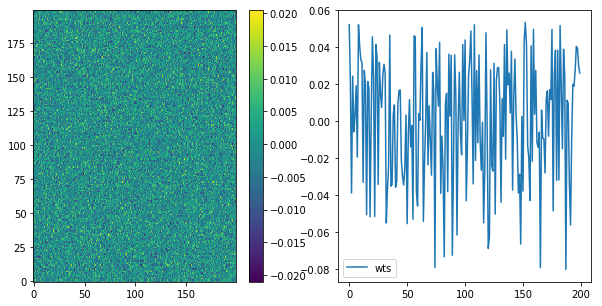

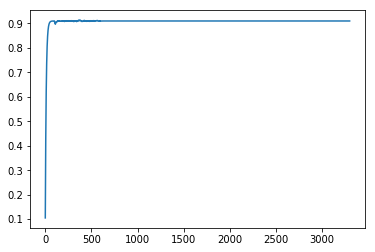

Cost: 0.4735405782414469


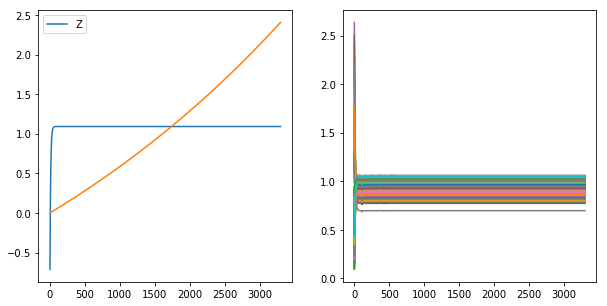

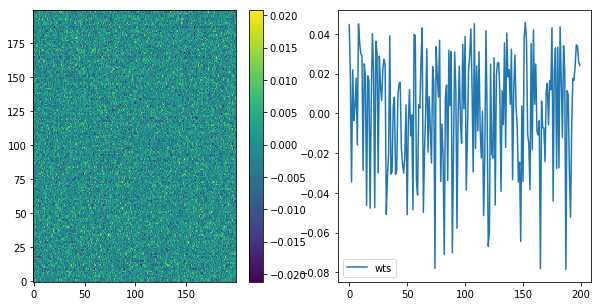

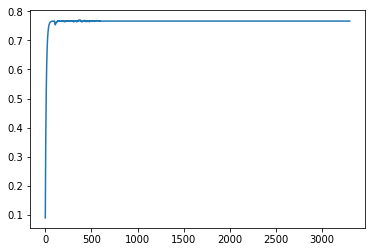

Cost: 0.4730703700608299


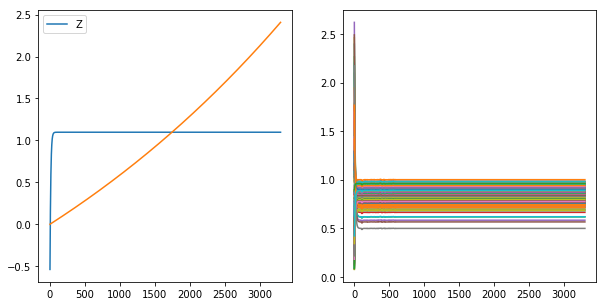

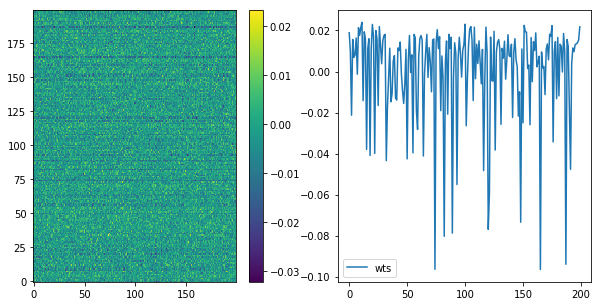

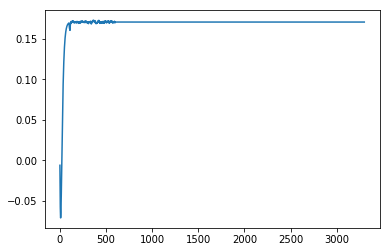

Cost: 0.5050097571800244


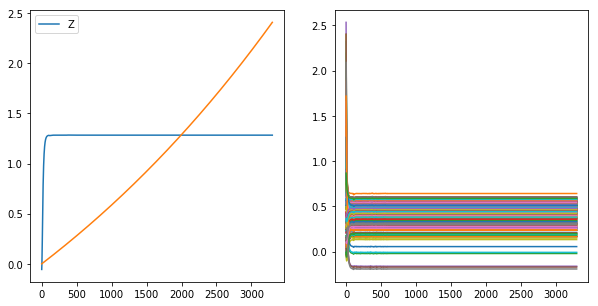

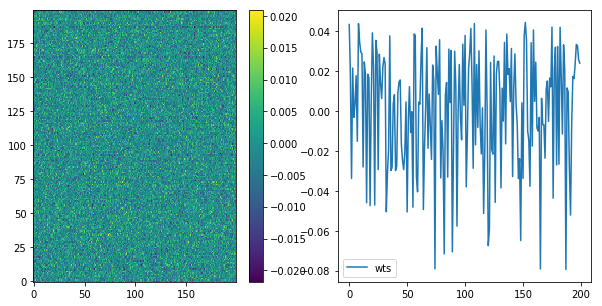

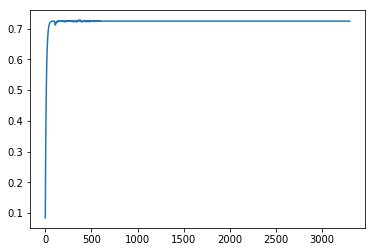

Cost: 0.47291621592312905


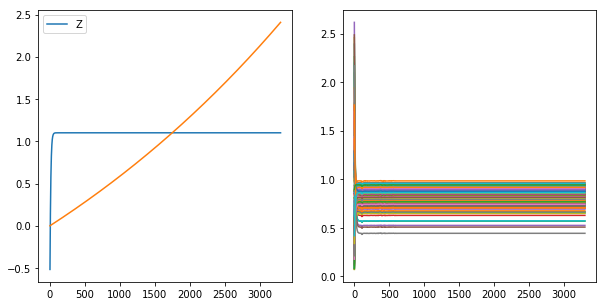

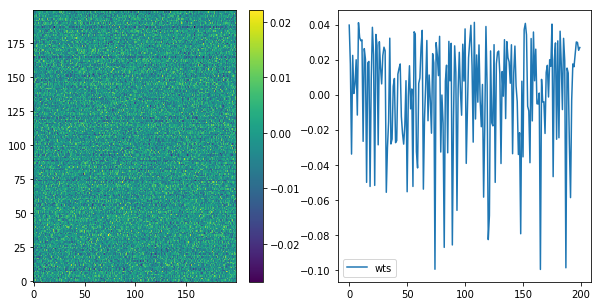

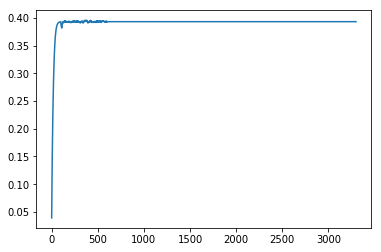

Cost: 0.47347440679304


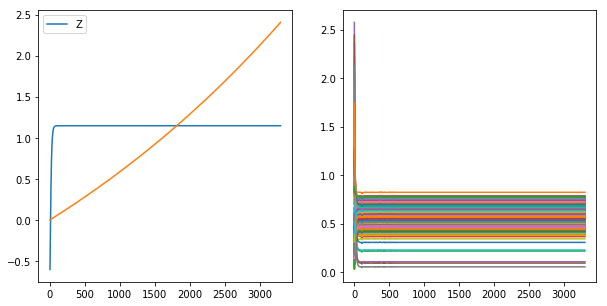

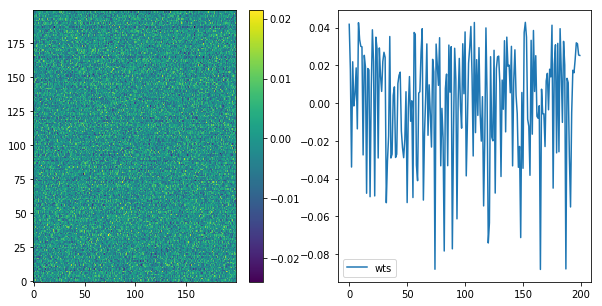

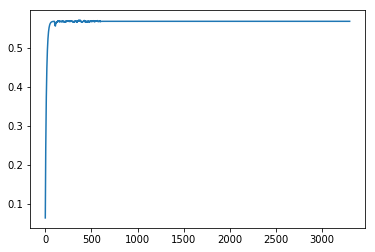

Cost: 0.4723251975757412


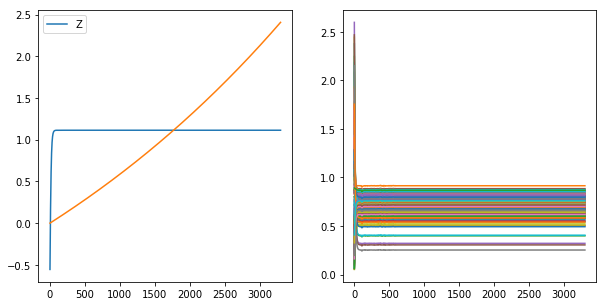

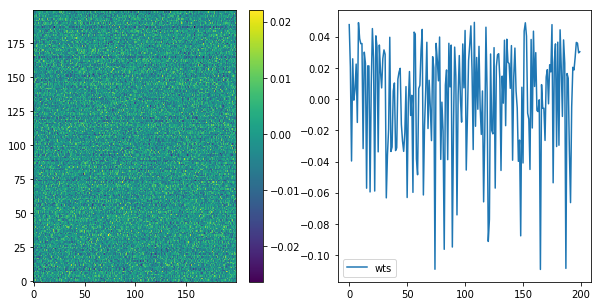

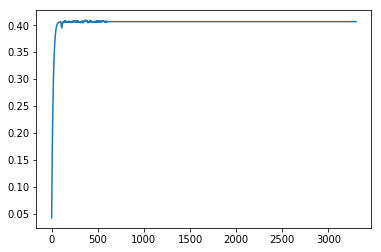

Cost: 0.47098257106366276


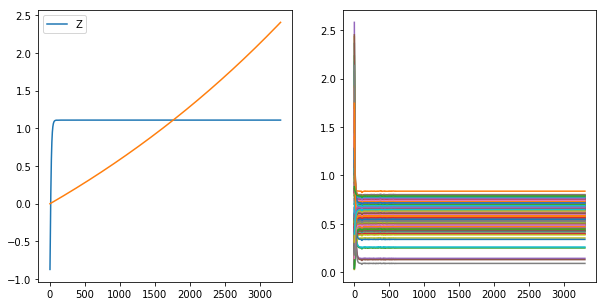

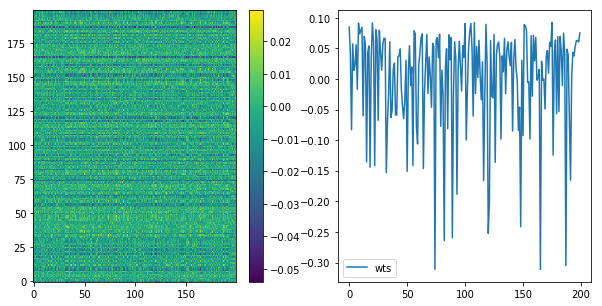

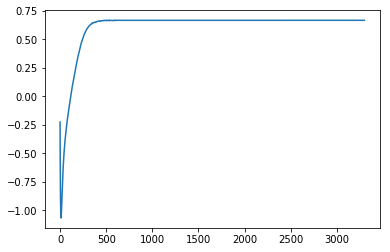

Cost: 15.155640581578194


ValueError: object too deep for desired array

<Figure size 720x360 with 2 Axes>

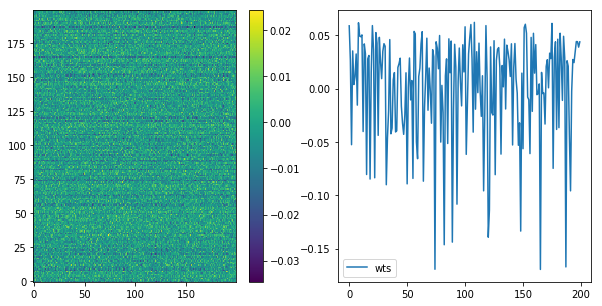

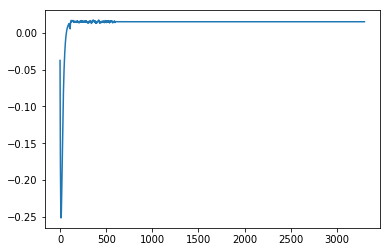

Cost: 0.4940427747090202


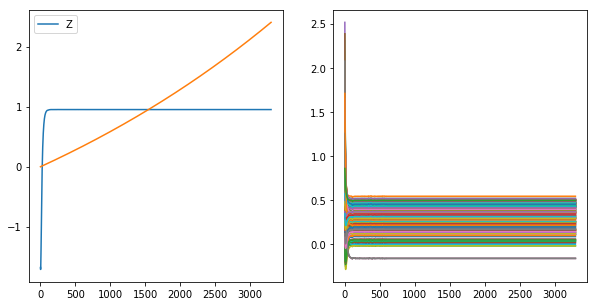

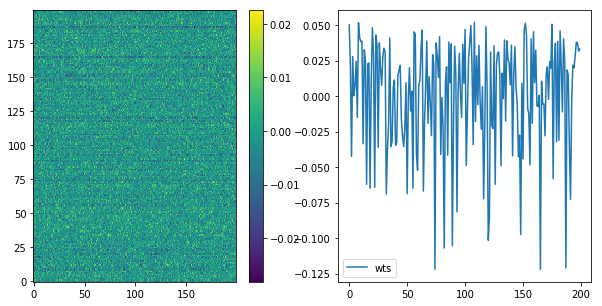

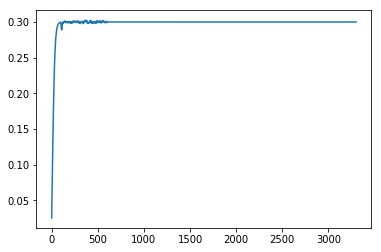

Cost: 0.4702664014039706


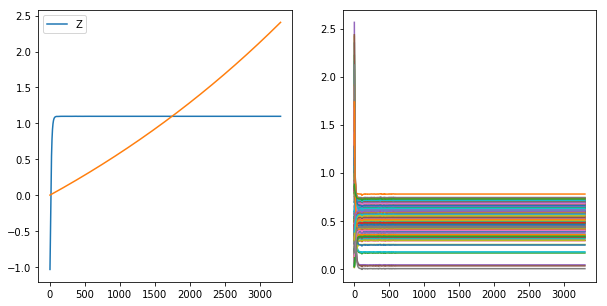

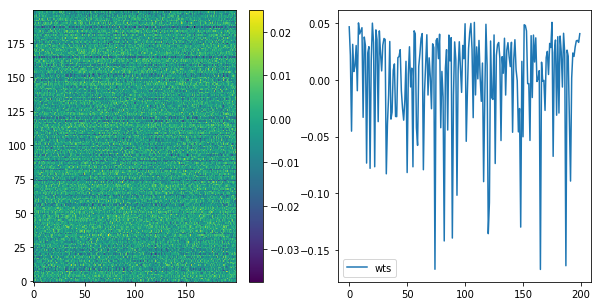

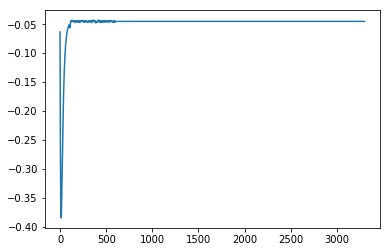

Cost: 0.4776998916045936


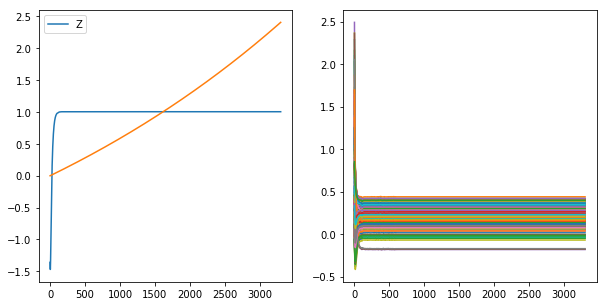

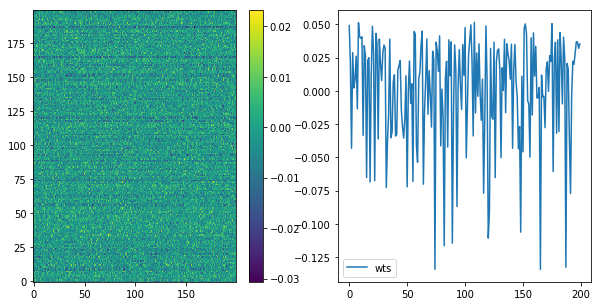

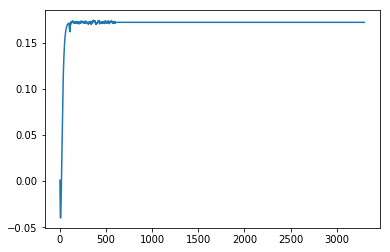

Cost: 0.469655043012947


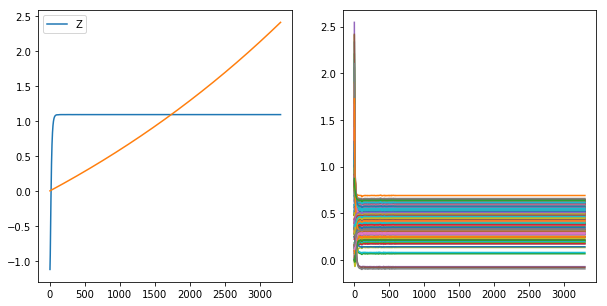

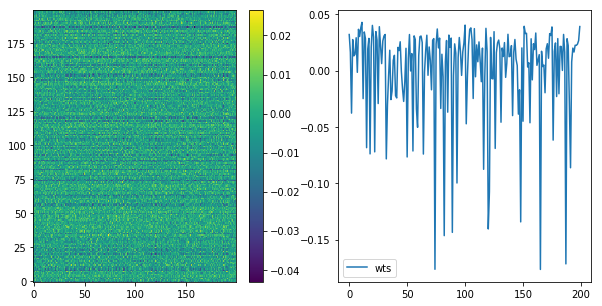

KeyboardInterrupt: 

In [14]:
rnn.grad_desc_lbfgs()